# Synthetic Control Method Analysis for France's Fertility Rate
This notebook analyzes the impact of a treatment on France's fertility rate using the Synthetic Control Method (SCM). Each cell is commented for clarity.

In [ ]:
# Load required libraries for SCM and data manipulation
library(Synth)
library(LowRankQP)
library(conflicted)
library(dplyr)
library(rvest)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(viridis)
library(hrbrthemes)
library(googlesheets4)
library(skimr)
library(kableExtra)
library(ggthemes)
library(stargazer)
library(kableExtra)
library(SCtools)

Loading required package: future



In [ ]:
# Load fertility data from Google Sheets
link <- "https://docs.google.com/spreadsheets/d/e/2PACX-1vQtL7A-QzQmTvFIIBzaRMLvFPVNFd5hNn-MwnbsmkkBj7ngVOXW9uDMgu_E44t-dPtQl4NlNVvBgzLJ/pub?gid=0&single=true&output=csv"
data <- read.csv(link, header=TRUE)
head(data)

,year,country,country_num,fertility_rate,gdp_per_capita,log_gdp,marriages_per_thousand,female_participation,female_avg_schooling,urban_population,age_young,age_old,non_religous,family_spending
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990,France,0,1.77,27992.98,10.23971,5.1,57.864,7.230000,74.056,30.56794,21.22484,0.16835,1.44
2,1991,France,0,1.75,28197.24,10.24698,4.9,58.110,7.424286,74.229,30.55329,21.61846,0.16835,1.44
3,1992,France,0,1.74,28482.52,10.25705,4.7,58.812,7.618571,74.401,30.49691,21.99131,0.16835,1.44
4,1993,France,0,1.73,28257.10,10.24910,4.4,59.516,7.812857,74.572,30.34065,22.34693,0.16835,1.48
5,1994,France,0,1.73,28822.50,10.26891,4.4,59.917,8.007143,74.743,30.13301,22.71598,0.16835,1.48
6,1995,France,0,1.74,29379.62,10.28806,4.4,60.501,8.201428,74.912,29.86362,23.09854,0.16835,1.50


In [ ]:
# Prepare data for SCM: define treated unit, donor pool, and treatment year
treated_unit <- "France"
donor_pool <- unique(data$country[data$country != treated_unit])

treated_year <- 1999

# Set up dataprep for SCM analysis
dataprep_out <- dataprep(
  foo = data,
  predictors = c("log_gdp", "marriages_per_thousand", "female_participation", "female_avg_schooling", "urban_population", "age_young"),
  dependent = "fertility_rate",
  unit.variable = "country_num",
  time.variable = "year",
  predictors.op = "mean",
  treatment.identifier = treated_unit,
  controls.identifier = donor_pool,
  time.predictors.prior = 1990:1999,  # Adjust the time range for the placebo test
  time.optimize.ssr = 1990:1999,  # Adjust the time range for the placebo test
  unit.names.variable = "country",
  time.plot = 1990:2010,  # Adjust the time range for the placebo test
)

# Run SCM
synth_out <- synth(dataprep_out)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.003206857 

solution.v:
 0.19263 0.6088801 0.1263538 9.59e-07 0.047929 0.02420616 

solution.w:
 0.1318486 0.007860608 1.29843e-05 0.0001823953 4.75095e-05 2.72786e-05 1.1214e-06 0.3158035 0.006519545 4.7804e-06 7.22623e-05 5.732e-06 8.5e-09 1.45729e-05 2.0946e-05 0.5373322 9.26531e-05 0.0001342918 1.90214e-05 



In [ ]:
# Print SCM results for France
print(synth_out)

$solution.v
     log_gdp marriages_per_thousand female_participation female_avg_schooling
BFGS 0.19263              0.6088801            0.1263538         9.589581e-07
     urban_population  age_young
BFGS         0.047929 0.02420616

$solution.w
       w.weight
1  1.318486e-01
2  7.860608e-03
3  1.298427e-05
4  1.823953e-04
5  4.750948e-05
6  2.727856e-05
7  1.121361e-06
8  3.158035e-01
9  6.519545e-03
10 4.780351e-06
11 7.226233e-05
12 5.732006e-06
13 8.455374e-09
14 1.457288e-05
15 2.094604e-05
16 5.373322e-01
17 9.265313e-05
18 1.342918e-04
19 1.902138e-05

$loss.v
            0
0 0.003206857

$loss.w
           w.weight
w.weight 0.01558583

$custom.v
NULL

$rgV.optim
$rgV.optim$out.list
                   p1        p2        p3            p4           p5         p6
BFGS        0.4105319 1.2976414 0.2692844 -2.043726e-06  0.102145998 0.05158803
Nelder-Mead 0.3844601 0.1175468 0.1320933 -1.841492e-07 -0.008314677 0.50004904
                  value fevals gevals niter convcode kkt1 k

In [ ]:
# Calculate the gap (treatment effect) and average increase in fertility rate after treatment
gaps <- dataprep_out$Y1plot - (dataprep_out$Y0plot %*% synth_out$solution.w)

years <- as.numeric(rownames(gaps))
post_treatment_gaps <- gaps[years >= 2000 & years <= 2010, ]

average_increase <- mean(post_treatment_gaps)
print(paste("Average increase in fertility rate (2000-2010):", round(average_increase, 4)))

[1] "Average increase in fertility rate (2000-2010): 0.163"


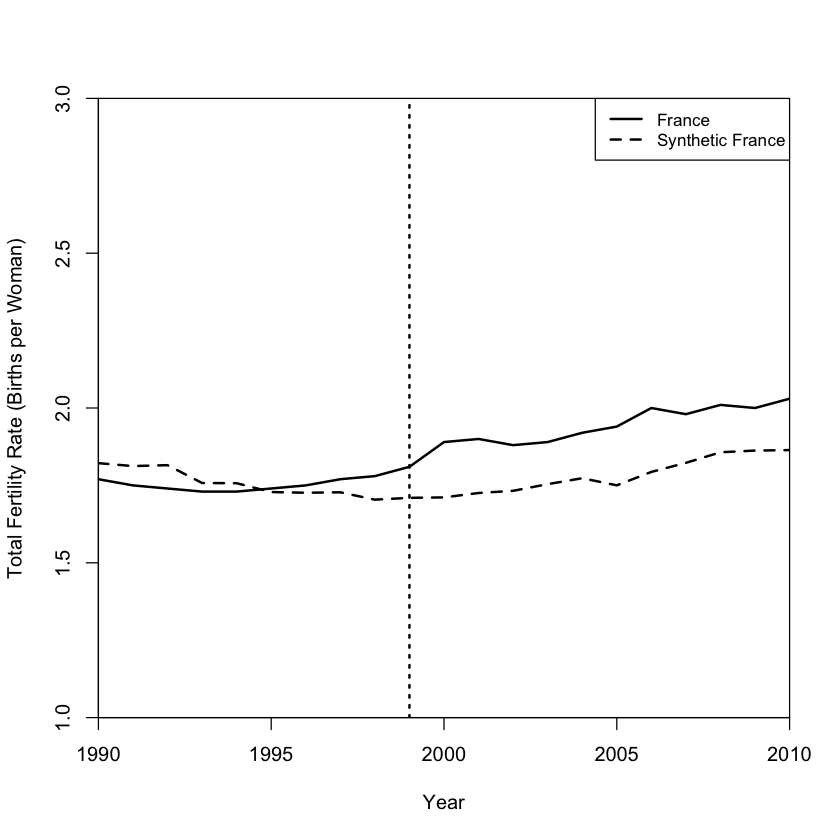

In [ ]:
# Plot the observed and synthetic fertility rates for France
path.plot(synth.res = synth_out,
          dataprep.res = dataprep_out,
          tr.intake = 1999,
          Ylab = "Total Fertility Rate (Births per Woman)",
          Xlab = "Year",
          Legend = c("France", "Synthetic France"),
        #   Main = "Figure 1: France vs. Synthetic France",
          Ylim = c(1,3)
        )



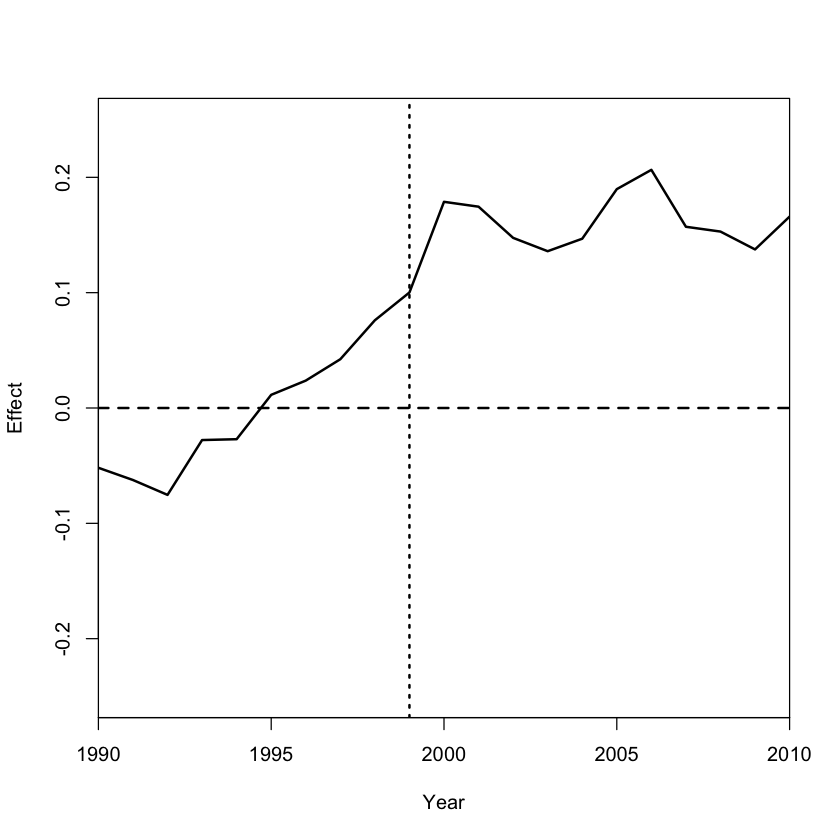

In [ ]:
# Plot the gap between observed and synthetic fertility rates
gaps.plot(synth.res = synth_out,
          dataprep.res = dataprep_out,
          tr.intake = 1999,
          Ylab = "Effect",
          Xlab = "Year",
          Main = c("")
        #   Main = "Figure 2: Gap between fertilities in France vs. Synthetic France""
        )

In [ ]:
# Placebo test: prepare data and run SCM for a different treatment year
treated_unit <- "France"
donor_pool <- unique(data$country[data$country != treated_unit])

treated_year <- 1994

dataprep_out_placebo <- dataprep(
  foo = data,
  predictors = c("log_gdp", "marriages_per_thousand", "female_participation", "female_avg_schooling", "urban_population", "age_young"),
  dependent = "fertility_rate",
  unit.variable = "country_num",
  time.variable = "year",
  predictors.op = "mean",
  treatment.identifier = treated_unit,
  controls.identifier = donor_pool,
  time.predictors.prior = 1990:1994,  # Adjust the time range for the placebo test
  time.optimize.ssr = 1990:1994,  # Adjust the time range for the placebo test
  unit.names.variable = "country",
  time.plot = 1990:2010,  # Adjust the time range for the placebo test
)

synth_out_placebo <- synth(dataprep_out_placebo)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.0001609865 

solution.v:
 0.04380313 0.6015944 0.06595197 0.03839471 0.05846986 0.1917859 

solution.w:
 0.0009970374 0.1489126 3.92726e-05 6.81453e-05 1.99988e-05 1.64884e-05 5.4068e-06 0.1785828 3.95629e-05 5.829e-07 9.0634e-06 1.65172e-05 0.000537974 1.86683e-05 3.74207e-05 0.5852432 0.08542768 1.78553e-05 9.6709e-06 



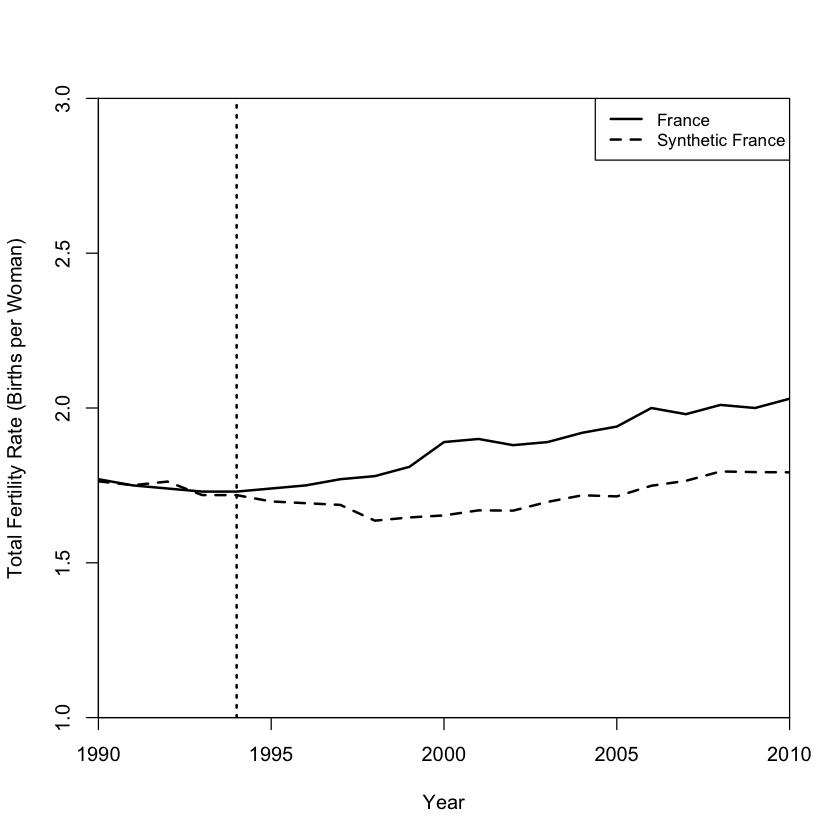

In [ ]:
# Plot the observed and synthetic fertility rates for the placebo test
path.plot(synth.res = synth_out_placebo,
          dataprep.res = dataprep_out_placebo,
          tr.intake = 1994,
          Ylab = "Total Fertility Rate (Births per Woman)",
          Xlab = "Year",
          Legend = c("France", "Synthetic France"),
        #   Main = "Figure 1: France vs. Synthetic France",
          Ylim = c(1,3)
        )


In [ ]:
# Show the main tables from the SCM results
synth_tables <- synth.tab(dataprep.res = dataprep_out, synth.res = synth_out)

synth_tables[1:3]


$tab.pred
                       Treated Synthetic Sample Mean
log_gdp                 10.290    10.289       9.592
marriages_per_thousand   4.710     4.781       5.502
female_participation    60.018    61.680      60.828
female_avg_schooling     8.104     9.625       9.366
urban_population        74.828    71.577      69.039
age_young               29.902    30.616      29.538

$tab.v
                       v.weights
log_gdp                0.193    
marriages_per_thousand 0.609    
female_participation   0.126    
female_avg_schooling   0        
urban_population       0.048    
age_young              0.024    

$tab.w
   w.weights unit.names unit.numbers
1      0.132      Italy            1
2      0.008      Spain            2
3      0.000    Austria            3
4      0.000     Greece            4
5      0.000     Poland            5
6      0.000   Slovakia            6
7      0.000    Romania            7
8      0.316    Ireland            8
9      0.007   Bulgaria            9
10     0.000  Lithuania           10
11     0.000     Latvia           11
12     0.000    Denmark           12
13     0.000     Norway           13
14     0.000    Iceland           14
15     0.000    Germany           15
16     0.537    Finland           16
17     0.000    Croatia           17
18     0.000    Estonia           18
19     0.000    Czechia           19

In [ ]:
# Generate placebo tests for inference
placebo <- generate.placebos(dataprep_out, synth_out, Sigf.ipop = 2, strategy='multicore')


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.0006869285 

solution.v:
 0.2935945 0.00989472 0.1530949 0.04639495 0.002118296 0.4949027 

solution.w:
 0.6851962 0.003691196 0.005543546 0.0005175408 0.000539809 0.001606326 0.0004992444 0.002282451 0.0005711463 0.001049847 0.002502173 0.001552091 3.45334e-05 0.2869704 0.001841424 0.002722082 0.000932615 0.001946302 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.003570569 

solution.v:
 0.05612418 0.2204187 0.001975996 0.4487957 0.2520434 0.02064212 

solution.w:
 0.6605911 0.0001448096 0.3155918 0.0001071959 0.001804193 0.0007258015 0.0001931011 0.01568981 0.0004429735 0.0001744591 8.08863e-05 1.20616e-05 0.0006305061 0.0001910032 0.000508267 0.0017064

New names:
* `w.weight` -> `w.weight...1`
* `w.weight` -> `w.weight...2`
* `w.weight` -> `w.weight...3`
* `w.weight` -> `w.weight...4`
* `w.weight` -> `w.weight...5`
* `w.weight` -> `w.weight...6`
* `w.weight` -> `w.weight...7`
* `w.weight` -> `w.weight...8`
* `w.weight` -> `w.weight...9`
* `w.weight` -> `w.weight...10`
* `w.weight` -> `w.weight...11`
* `w.weight` -> `w.weight...12`
* `w.weight` -> `w.weight...13`
* `w.weight` -> `w.weight...14`
* `w.weight` -> `w.weight...15`
* `w.weight` -> `w.weight...16`
* `w.weight` -> `w.weight...17`
* `w.weight` -> `w.weight...18`
* `w.weight` -> `w.weight...19`


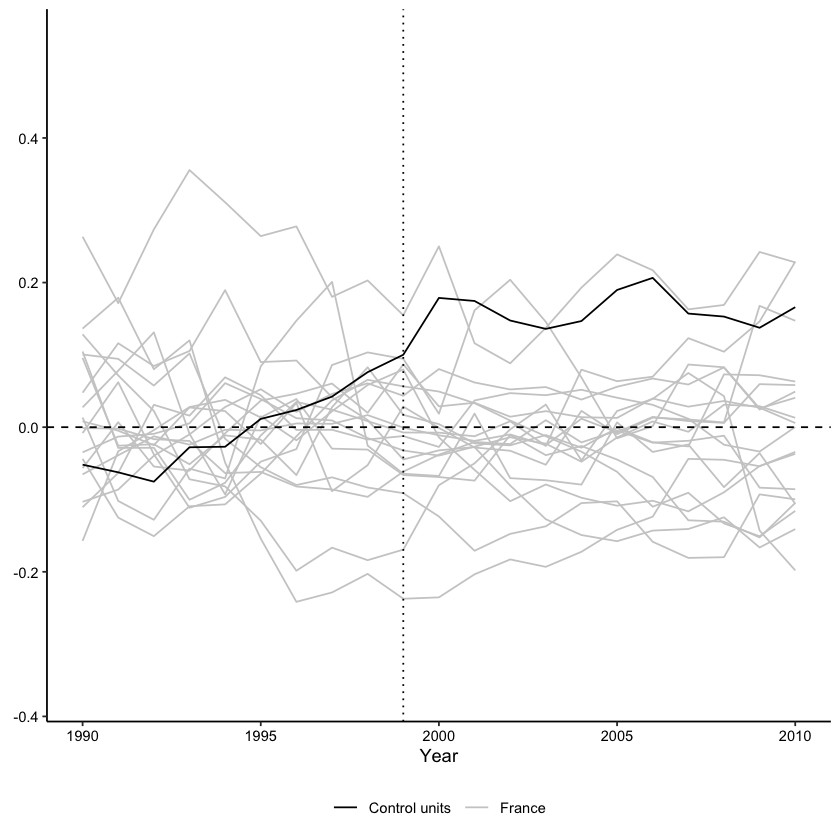

In [ ]:
# Plot placebo results (all units)
p <- plot_placebos(placebo, discard.extreme=FALSE, xlab='Year')
p

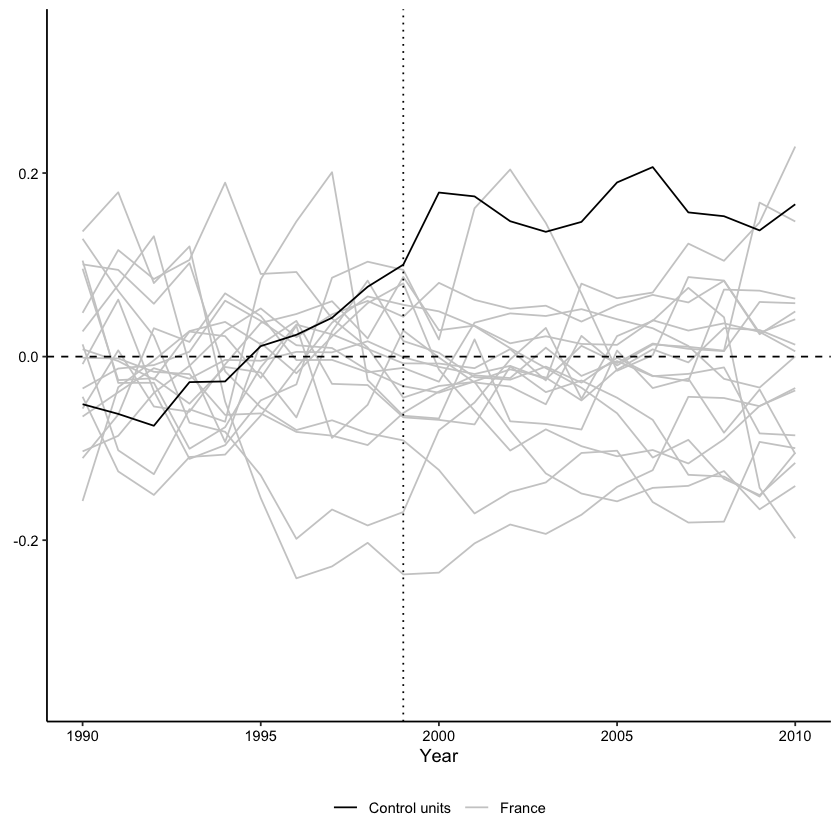

In [ ]:
# Plot placebo results (excluding extreme MSPE)
p <- plot_placebos(placebo, discard.extreme=TRUE, mspe.limit=15, xlab='Year')
p

In [ ]:
# (Empty cell for spacing or future use)

In [ ]:
# Calculate and print the p-value for the placebo test
ratio <- mspe.test(placebo)
print(ratio$p.val)



[1] 0.05


In [ ]:
# Print the test statistic for the placebo test
print(ratio$test)

   MSPE.ratios      unit
1    1.1420348     Italy
2    0.4653706     Spain
3    2.2012689   Austria
4    0.8336447    Greece
5    1.7608137    Poland
6    3.1281440  Slovakia
7    0.6254015   Romania
8    1.7609627   Ireland
9    3.3477545  Bulgaria
10   1.6284670 Lithuania
11   0.4090194    Latvia
12   1.1143982   Denmark
13   0.2723206    Norway
14   0.5811257   Iceland
15   0.9821069   Germany
16   0.4959935   Finland
17   0.3558484   Croatia
18   3.4424733   Estonia
19   0.7161483   Czechia
20   8.4307456    France


Warning message in mspe.plot(placebo, discard.extreme = FALSE, mspe.limit = 1000, :
"discard.extreme is FALSE. mspe.limit will be ignored."


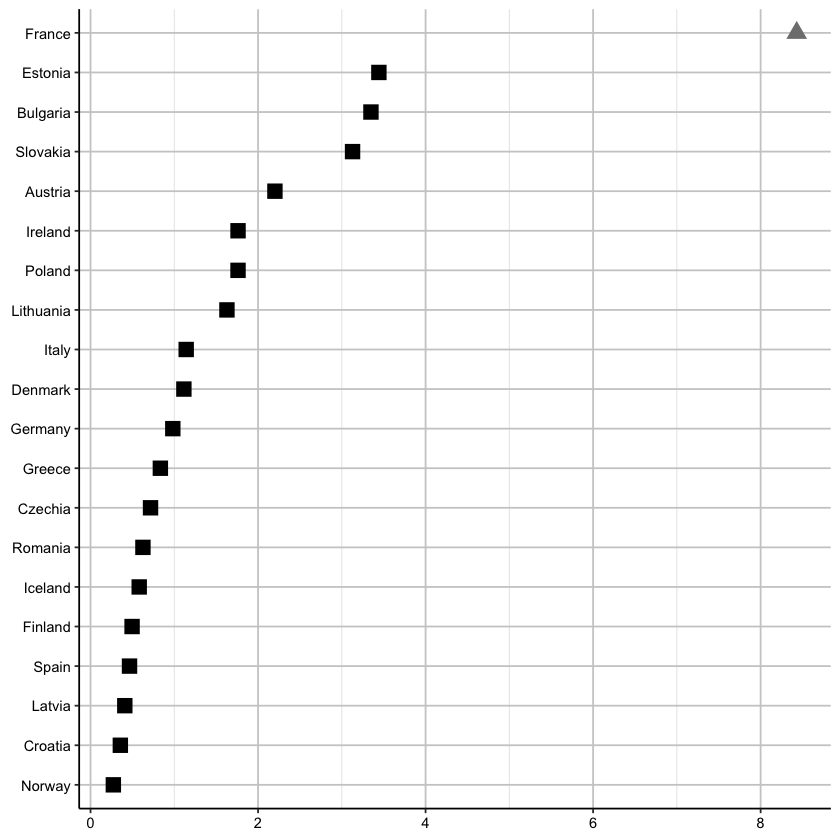

In [ ]:
# Plot MSPE ratios for all units in the placebo test
mspe.plot(
  placebo,
  discard.extreme = FALSE,
  mspe.limit = 1000,
  plot.hist = FALSE,
  title = NULL,
  xlab = NULL, # "Post/Pre MSPE ratio",
  ylab = NULL
)

In [ ]:
# (Empty cell for spacing or future use)